# EMOJIFY

## IMPORTING NECESSARY PACKAGES

In [163]:
#For emojis
import emoji
#For Data Manipulation
import pandas as pd
#For numerical array calculations
import numpy as np
#For natutal language tasks
import nltk
import re
#To ignore warning 
import warnings
warnings.filterwarnings('ignore')
#For IMDB dataset
import keras
from keras.datasets import imdb

# GETTING THE DATA

In [164]:
# We have a  training and testing dataset in form of csv let's import and explore it 
print('TRAINING DATA')
train_data=pd.read_csv('data/train_emoji.csv',header=None)
#Let's look at the data and its shape
print(train_data.head())
print()
print('Size of the  training data is {}'.format(train_data.shape))
print('TESTING DATA')
test_data=pd.read_csv('data/tess.csv',header=None)
print(test_data.head())
print()
print('Size of testing data {}'.format(test_data.shape))

TRAINING DATA
                                 0  1   2     3
0           never talk to me again  3 NaN   NaN
1  I am proud of your achievements  2 NaN   NaN
2   It is the worst day in my life  3 NaN   NaN
3                 Miss you so much  0 NaN   [0]
4                     food is life  4 NaN   NaN

Size of the  training data is (132, 4)
TESTING DATA
                            0  1
0             I want to eat\t  4
1         he did not answer\t  3
2            he got a raise\t  2
3      she got me a present\t  2
4  ha ha ha it was so funny\t  2

Size of testing data (56, 2)


**Here** 
- 0 represent Love emoji
- 1 represent baseball emoji
- 2 represent smile emoji
- 3 reprsent  sad emoji
- 4 represent fork and knife emoji

In [165]:
#making a dictionary to encode label into emoji
emoji_dictionary={
    "0" : "\u2764\uFE0F" ,
    "1" : ":baseball:" ,
    "2" : ":grinning_face_with_big_eyes:" ,
    "3" : ":disappointed_face:" ,
    "4" : ":fork_and_knife:" ,
}

In [166]:
for i , w in emoji_dictionary.items() :
    print('{} reprsent {}'.format(i,emoji.emojize(w)))

0 reprsent ❤️
1 reprsent ⚾
2 reprsent 😃
3 reprsent 😞
4 reprsent 🍴


**Our goal is to input a sentence and find most appropriate emoji for the sentence we have a training data of 132 traning example and 56 testing/validation example**

## DATA CLEANING

#### REMOVING UNNECESSARY COLUMNS

In [167]:
#Selecting all rows and selecting columns
X_train=train_data[0]
Y_train=train_data[1]
X_test=test_data[0]
Y_test=test_data[1]

In [168]:
#Let's look at input
for i in range(0,5):
    print(X_train[i]+' '+emoji.emojize(emoji_dictionary[str(Y_train[i])]))

never talk to me again 😞
I am proud of your achievements 😃
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴


#### NORMALIZING,PUNCTUATION REMOVAL,TOKENIZATION

In [169]:
#We will write a function to do basic cleaning
#Import word tokenize form nltk to perform tokenization
from nltk.tokenize import word_tokenize
def cleaning(text) :
    #Normalizing the data
    text=str(text)
    text=text.lower()
    #removing punctuation
    text=re.sub('[^A-Za-z0-9]',' ',text)
    #Tokenization
    text=word_tokenize(text)
    return text

In [170]:
#Performing datacleaning
X_train=X_train.apply(cleaning)
X_test =X_test.apply(cleaning)

## PREPROCESSING DATA

In [171]:
#Making one hot_vectors
Y_train=pd.get_dummies(Y_train.values)
y_test=pd.get_dummies(Y_test.values)

#### LEARNING WORD EMBEDDING

In [172]:
#Importing tokenizer
from keras.preprocessing.text import Tokenizer
#Making object of Tokenizer Class
tokenizer=Tokenizer()
#Fitting object on review column
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
#Claculating the vocabulary size as it is useful in Embedding layer jst adding 1 for embedding matrix
vocab_size = len(tokenizer.word_index)+1
#Printing size of vocabulary
print('Vocubalary size is equal to {}'.format(vocab_size-1))

Vocubalary size is equal to 310


In [175]:
#Converting texts to sequences
X_train_token=tokenizer.texts_to_sequences(X_train)
X_test_token=tokenizer.texts_to_sequences(X_test)

In [176]:
#Calculating maximum length which will be useful in padding
maxlength=max([len(s) for s in X_train_token])
print('Maximum length of sequence in training set is {}'.format(maxlength))
maxlength_test=max([len(s) for s in X_test_token])
print('Maximum length of sequence in testing set is {}'.format(maxlength_test))

Maximum length of sequence in training set is 10
Maximum length of sequence in testing set is 8


#### PADDING

In [177]:
#Importing module
from keras.preprocessing.sequence import pad_sequences
#Performing padding
X_train_token_pd=pad_sequences(X_train_token,maxlen=maxlength,padding='pre')
X_test_token_pd=pad_sequences(X_test_token,maxlen=maxlength_test,padding='pre')

## DEFINING MODEL(SIMPLE RNN MODEL)

In [178]:
#Importing necessary modules for Deep learning
import tensorflow
import keras
from keras.layers import Dense,Embedding,SimpleRNN,Dropout
from keras.models import Sequential

In [179]:
#Creating a sequential model
model=Sequential()
#Creating a embedding layer which will learn embedding for us which will 128 dimensional vector
model.add(Embedding(vocab_size,128))
#Creating a two stacked Simple RNN layer of hidden  units = 128
model.add(SimpleRNN(128,return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(128,return_sequences=False))
model.add(Dropout(0.5))
#Adding dense layer
model.add(Dense(100,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [180]:
# COMPILING THE MODEL with adam optimization algorithm
model.compile(optimizer='adam',loss='categorical_crossentropy')

In [181]:
#Fitiing the model
training=model.fit(X_train_token_pd,Y_train,validation_data=[X_test_token_pd,y_test],batch_size=32,epochs=200)

Train on 132 samples, validate on 56 samples
Epoch 1/200
132/132 [==============================] - 1s 6ms/step - loss: 1.5982 - val_loss: 1.5488
Epoch 2/200
132/132 [==============================] - 0s 325us/step - loss: 1.5743 - val_loss: 1.5603
Epoch 3/200
132/132 [==============================] - 0s 332us/step - loss: 1.5394 - val_loss: 1.5158
Epoch 4/200
132/132 [==============================] - 0s 295us/step - loss: 1.5283 - val_loss: 1.5080
Epoch 5/200
132/132 [==============================] - 0s 310us/step - loss: 1.5065 - val_loss: 1.5388
Epoch 6/200
132/132 [==============================] - 0s 295us/step - loss: 1.4672 - val_loss: 1.5133
Epoch 7/200
132/132 [==============================] - 0s 272us/step - loss: 1.4546 - val_loss: 1.4773
Epoch 8/200
132/132 [==============================] - 0s 272us/step - loss: 1.3744 - val_loss: 1.5108
Epoch 9/200
132/132 [==============================] - 0s 280us/step - loss: 1.3053 - val_loss: 1.5035
Epoch 10/200
132/132 [========

132/132 [==============================] - 0s 295us/step - loss: 0.0026 - val_loss: 2.6650
Epoch 80/200
132/132 [==============================] - 0s 295us/step - loss: 0.0058 - val_loss: 2.6765
Epoch 81/200
132/132 [==============================] - 0s 317us/step - loss: 0.0046 - val_loss: 2.6939
Epoch 82/200
132/132 [==============================] - 0s 257us/step - loss: 0.0036 - val_loss: 2.7142
Epoch 83/200
132/132 [==============================] - 0s 234us/step - loss: 0.0059 - val_loss: 2.7492
Epoch 84/200
132/132 [==============================] - 0s 227us/step - loss: 0.0040 - val_loss: 2.8111
Epoch 85/200
132/132 [==============================] - 0s 234us/step - loss: 0.0018 - val_loss: 2.8469
Epoch 86/200
132/132 [==============================] - 0s 234us/step - loss: 0.0018 - val_loss: 2.8611
Epoch 87/200
132/132 [==============================] - 0s 234us/step - loss: 0.0023 - val_loss: 2.8574
Epoch 88/200
132/132 [==============================] - 0s 234us/step - loss:

132/132 [==============================] - 0s 249us/step - loss: 4.5566e-04 - val_loss: 3.0812
Epoch 157/200
132/132 [==============================] - 0s 257us/step - loss: 0.0010 - val_loss: 3.0739
Epoch 158/200
132/132 [==============================] - 0s 249us/step - loss: 5.9873e-04 - val_loss: 3.0673
Epoch 159/200
132/132 [==============================] - 0s 234us/step - loss: 5.1160e-04 - val_loss: 3.0641
Epoch 160/200
132/132 [==============================] - 0s 242us/step - loss: 4.2419e-04 - val_loss: 3.0626
Epoch 161/200
132/132 [==============================] - 0s 242us/step - loss: 5.6572e-04 - val_loss: 3.0629
Epoch 162/200
132/132 [==============================] - 0s 242us/step - loss: 6.0307e-04 - val_loss: 3.0677
Epoch 163/200
132/132 [==============================] - 0s 242us/step - loss: 5.7279e-04 - val_loss: 3.0719
Epoch 164/200
132/132 [==============================] - 0s 249us/step - loss: 4.3013e-04 - val_loss: 3.0755
Epoch 165/200
132/132 [==============

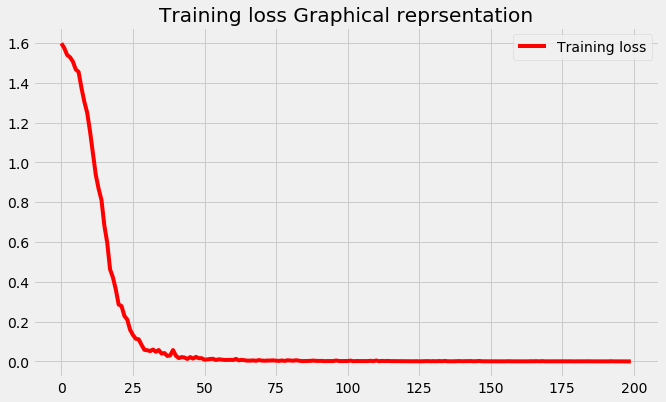

In [182]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
plt.plot(training.history['loss'],label='Training loss',color='red')
plt.title('Training loss Graphical reprsentation')
plt.legend(loc='upper right')
plt.show()

## TESTING TIME

In [185]:
## A function which will take in the input sentence and predict the emoji
def prediction (data) :
    encoded=cleaning([data])
    encod_list=[[]]
    for w in encoded :
        if w in tokenizer.word_index.keys():
            encod_list[0].append(tokenizer.word_index[w])
        else :
            encod_list[0].append(0)
    encoded = pad_sequences(encod_list,maxlen=maxlength,padding='pre')
    return encoded
def model_out () :
    data=input("Enter your sentence------>")
    encod=prediction(data)
    emoj=str(model.predict_classes(encod)[0])
    print(encod)
    print('Predicted emoji {}'.format(emoji.emojize(emoji_dictionary[str(emoj)])))
        

In [186]:
model_out()

Enter your sentence------>I love Machine learning
[[ 0  0  0  0  0  0  1 19  0  0]]
Predicted emoji ❤️


## MODEL USING GLOVE (PRETRAINED EMBEDDING) AND BIDIRECTIONAL LSTM

In [195]:
#we have a glove 50 dimensional word embedding let's unbox it and we will make embedding matrix using it 
f = open('glove.6B.50d.txt',encoding='utf-8')
#Making a dictionary to store word embeddings
word_to_vec={}
for line in f :
    values=line.split()
    word_to_vec[values[0]]=np.array(values[1:])
f.close

<function TextIOWrapper.close()>

In [216]:
#All our work is done already we just have to make a embedding matrix
#Initialzing embedding matrix
np.random.seed(42)
embedding_matrix=np.random.rand(vocab_size,50)
for w , i in tokenizer.word_index.items() :
    encoding_vector=word_to_vec[w]
    if encoding_vector is not None :
        embedding_matrix[i] = encoding_vector

# DEFINING MODEL

In [233]:
from keras.layers import LSTM
model1 = Sequential()
model1.add(Embedding(vocab_size,50,weights=[embedding_matrix],trainable=False))
model1.add((LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model1.add((LSTM(256)))
model1.add(Dropout(0.25))
model1.add(Dense(units=5, activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [234]:
#Fitiing the model
training1=model1.fit(X_train_token_pd,Y_train,validation_data=[X_test_token_pd,y_test],batch_size=32,epochs=200)

Train on 132 samples, validate on 56 samples
Epoch 1/200
132/132 [==============================] - 2s 15ms/step - loss: 1.5848 - acc: 0.2121 - val_loss: 1.5383 - val_acc: 0.2857
Epoch 2/200
132/132 [==============================] - 0s 2ms/step - loss: 1.6019 - acc: 0.2955 - val_loss: 1.5164 - val_acc: 0.2857
Epoch 3/200
132/132 [==============================] - 0s 2ms/step - loss: 1.4777 - acc: 0.3864 - val_loss: 1.5286 - val_acc: 0.4286
Epoch 4/200
132/132 [==============================] - 0s 2ms/step - loss: 1.4441 - acc: 0.5758 - val_loss: 1.4678 - val_acc: 0.4464
Epoch 5/200
132/132 [==============================] - 0s 2ms/step - loss: 1.3878 - acc: 0.4394 - val_loss: 1.4055 - val_acc: 0.3750
Epoch 6/200
132/132 [==============================] - 0s 2ms/step - loss: 1.3243 - acc: 0.4242 - val_loss: 1.3725 - val_acc: 0.3929
Epoch 7/200
132/132 [==============================] - 0s 2ms/step - loss: 1.2378 - acc: 0.4773 - val_loss: 1.3356 - val_acc: 0.4821
Epoch 8/200
132/132 [==

Epoch 62/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.9780 - val_acc: 0.7321
Epoch 63/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 1.0291 - val_acc: 0.7500
Epoch 64/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 1.0681 - val_acc: 0.7500
Epoch 65/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.0656 - val_acc: 0.7500
Epoch 66/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 1.0017 - val_acc: 0.7500
Epoch 67/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.9859 - val_acc: 0.7500
Epoch 68/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0065 - val_acc: 0.7500
Epoch 69/200
132/132 [==============================] - 0s 2ms

132/132 [==============================] - 0s 2ms/step - loss: 6.5263e-04 - acc: 1.0000 - val_loss: 1.0853 - val_acc: 0.7679
Epoch 123/200
132/132 [==============================] - 0s 2ms/step - loss: 6.1160e-04 - acc: 1.0000 - val_loss: 1.0855 - val_acc: 0.7500
Epoch 124/200
132/132 [==============================] - 0s 2ms/step - loss: 6.2801e-04 - acc: 1.0000 - val_loss: 1.0895 - val_acc: 0.7500
Epoch 125/200
132/132 [==============================] - 0s 2ms/step - loss: 4.3554e-04 - acc: 1.0000 - val_loss: 1.1119 - val_acc: 0.7500
Epoch 126/200
132/132 [==============================] - 0s 2ms/step - loss: 5.1027e-04 - acc: 1.0000 - val_loss: 1.1398 - val_acc: 0.7500
Epoch 127/200
132/132 [==============================] - 0s 2ms/step - loss: 7.0352e-04 - acc: 1.0000 - val_loss: 1.1645 - val_acc: 0.7500
Epoch 128/200
132/132 [==============================] - 0s 2ms/step - loss: 4.7928e-04 - acc: 1.0000 - val_loss: 1.1588 - val_acc: 0.7500
Epoch 129/200
132/132 [==================

132/132 [==============================] - 0s 2ms/step - loss: 2.5072e-04 - acc: 1.0000 - val_loss: 1.1532 - val_acc: 0.7500
Epoch 182/200
132/132 [==============================] - 0s 2ms/step - loss: 2.2167e-04 - acc: 1.0000 - val_loss: 1.1728 - val_acc: 0.7500
Epoch 183/200
132/132 [==============================] - 0s 2ms/step - loss: 2.2057e-04 - acc: 1.0000 - val_loss: 1.1831 - val_acc: 0.7500
Epoch 184/200
132/132 [==============================] - 0s 2ms/step - loss: 3.1261e-04 - acc: 1.0000 - val_loss: 1.1646 - val_acc: 0.7500
Epoch 185/200
132/132 [==============================] - 0s 2ms/step - loss: 2.0633e-04 - acc: 1.0000 - val_loss: 1.1348 - val_acc: 0.7679
Epoch 186/200
132/132 [==============================] - 0s 2ms/step - loss: 2.3680e-04 - acc: 1.0000 - val_loss: 1.1213 - val_acc: 0.7679
Epoch 187/200
132/132 [==============================] - 0s 2ms/step - loss: 2.0048e-04 - acc: 1.0000 - val_loss: 1.1472 - val_acc: 0.7500
Epoch 188/200
132/132 [==================

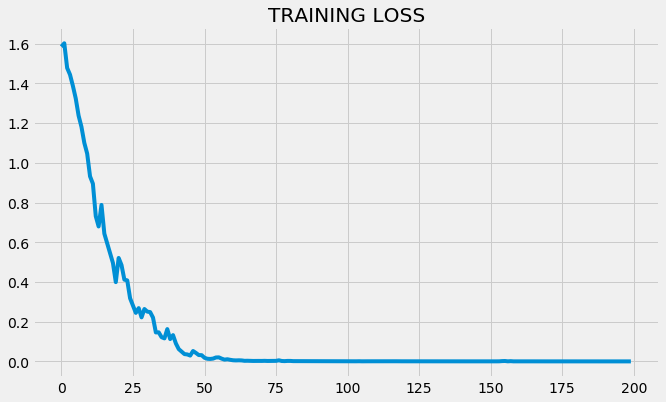

In [236]:
plt.figure(figsize=(10,6))
plt.plot(training1.history['loss'],label='Training loss')
plt.title('TRAINING LOSS')
plt.show()

## TESTING TIME

In [238]:
def prediction (data) :
    encoded=cleaning([data])
    encod_list=[[]]
    for w in encoded :
        if w in tokenizer.word_index.keys() :
            encod_list[0].append(tokenizer.word_index[w])
        else :
            encod_list[0].append(0)
    encoded = pad_sequences(encod_list,maxlen=maxlength,padding='pre')
    return encoded
def model_out () :
    data=input("Enter your sentence------>")
    encod=prediction(data)
    emoj=str(model1.predict_classes(encod)[0])
    print(encod)
    print('Predicted emoji {}'.format(emoji.emojize(emoji_dictionary[str(emoj)])))

In [240]:
model_out()

Enter your sentence------>India is best country
[[  0   0   0   0   0   0   0   3 181   0]]
Predicted emoji 😃
